# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.


Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста. MAE модели должна быть не больше 8.

# Загрузка данных и обзор

Загрузим данные и посмотрим на предоставленные данные

In [1]:
!gdown --id 1cVhkngZ2ku9cVZ01g7TUsUcGUco7gvzM

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1cVhkngZ2ku9cVZ01g7TUsUcGUco7gvzM
To: /content/archive.zip
100% 240M/240M [00:04<00:00, 52.7MB/s]


In [2]:
!unzip -q /content/archive.zip

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

Константы

In [4]:
PATH = '/content/'
BATCH_SIZE = 32
INPUT_SHAPE = (224, 224, 3)
LR = 0.0003
EPOCHS = 15

Загрузка данных

In [5]:
labels = pd.read_csv(PATH + 'labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=PATH + 'final_files/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    seed=101)

Found 7591 validated image filenames.


Размер выборки

In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Посмотрим на распределение возраста покупателей

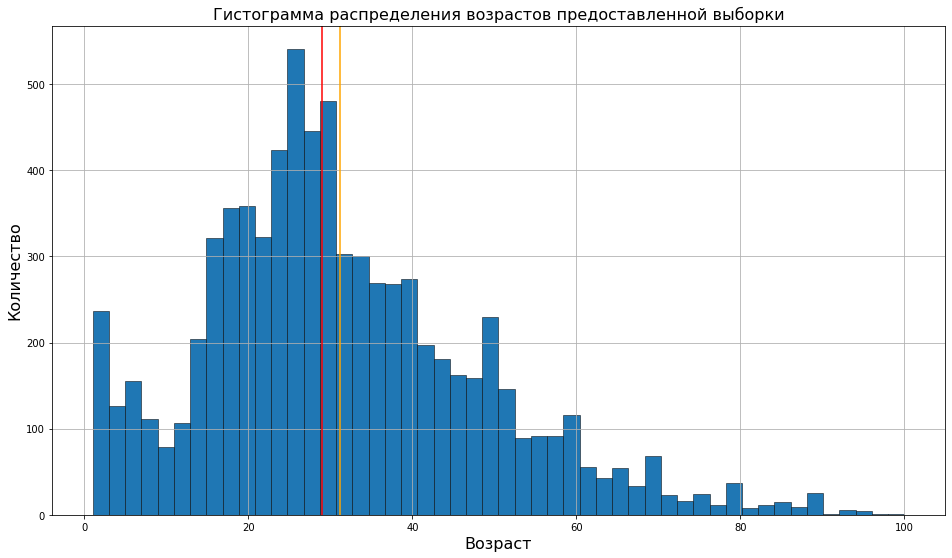


Средний возраст: 31.20115926755368 (оранжевая линия)
Медианный возраст: 29.0 (красная линия)


In [7]:
#Calculating parameters    
values = labels['real_age']
mean = values.mean()
median = values.median()
    
#Plotting
plt.figure(figsize=(16,9))
plt.hist(values, bins=50, linewidth=0.5, edgecolor='black')
plt.xlabel('Возраст', fontsize=16)
plt.ylabel('Количество', fontsize=16)
plt.title('Гистограмма распределения возрастов предоставленной выборки', fontsize=16)
plt.axvline(x=mean, color='orange')
plt.axvline(x=median, color='red')
plt.grid()
plt.show()

#Text
print()
print("Средний возраст:", mean, '(оранжевая линия)')
print("Медианный возраст:", median, '(красная линия)')

Забавно, что среди выборки есть достаточно много детей грудного возраста. Оставим их для адекватного определения возраста моделью. Посмотрим на изображения лиц.

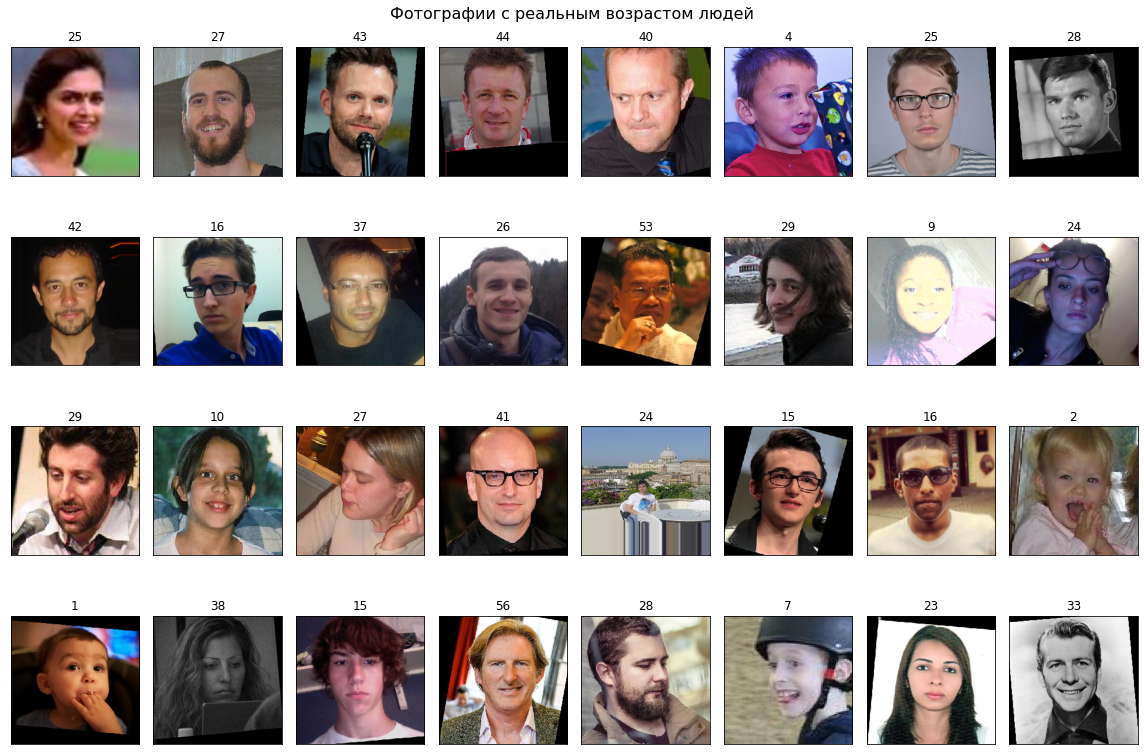

In [8]:
features, target = next(train_gen_flow)

# show 32 pic
fig = plt.figure(figsize=(16,12))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
	# delete axis
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Фотографии с реальным возрастом людей', y=0.95, fontsize=16)
    plt.tight_layout()

## Вывод

Данные успешно загружены и готовы.

# Обучение модели

В качестве модели будет использовать **ResNet50**. 

Создадим 4 функции, две для загрузки данных, одну для создания модели и одну для ее обучения.

In [9]:
def load_train(path):

    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                        validation_split=0.25,
                                        rescale=1./255)

    train_datagen_flow = train_datagen.flow_from_dataframe(
              dataframe=pd.read_csv(path + 'labels.csv'),
              directory=path + 'final_files/final_files',
              x_col='file_name',
              y_col='real_age',
              target_size=(224, 224),
              batch_size=BATCH_SIZE,
              class_mode='raw',
              subset='training',
              seed=101)

    return train_datagen_flow

In [10]:
def load_test(path):

    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                      validation_split=0.25,
                                      rescale=1./255)


    test_datagen_flow = test_datagen.flow_from_dataframe(
            dataframe=pd.read_csv(path + 'labels.csv'),
            directory=path + 'final_files/final_files',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=BATCH_SIZE,
            class_mode='raw',
            subset='validation',
            seed=101)

    return test_datagen_flow

In [11]:
def create_model(input_shape, learning_rate):

    optimizer = Adam(learning_rate=learning_rate)

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(Dropout(0.2))        
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [12]:
def train_model(model, train_datagen_flow, test_datagen_flow, batch_size=None, 
                epochs=EPOCHS, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
            steps_per_epoch = len(train_datagen_flow)
    if validation_steps is None:
            validation_steps = len(test_datagen_flow)
    model.fit(train_datagen_flow,
            validation_data=test_datagen_flow,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            verbose=2, epochs=epochs)

    return model

Теперь вызовем эти функции

In [13]:
train_datagen_flow = load_train(PATH)

Found 5694 validated image filenames.


In [14]:
test_datagen_flow = load_test(PATH)

Found 1897 validated image filenames.


In [15]:
model = create_model(INPUT_SHAPE, LR)

94781440/94765736 [==============================] - 1s 0us/step


In [16]:
history = train_model(model, train_datagen_flow, test_datagen_flow)

Epoch 1/15
178/178 - 96s - loss: 182.5780 - mae: 10.0042 - val_loss: 355.1382 - val_mae: 14.0424 - 96s/epoch - 542ms/step
Epoch 2/15
178/178 - 74s - loss: 81.3260 - mae: 6.8790 - val_loss: 403.5535 - val_mae: 15.0751 - 74s/epoch - 414ms/step
Epoch 3/15
178/178 - 74s - loss: 49.0047 - mae: 5.3187 - val_loss: 243.8447 - val_mae: 11.8471 - 74s/epoch - 417ms/step
Epoch 4/15
178/178 - 73s - loss: 37.7185 - mae: 4.7418 - val_loss: 123.4074 - val_mae: 8.3969 - 73s/epoch - 413ms/step
Epoch 5/15
178/178 - 73s - loss: 27.0316 - mae: 4.0400 - val_loss: 130.9507 - val_mae: 9.1608 - 73s/epoch - 412ms/step
Epoch 6/15
178/178 - 74s - loss: 19.3712 - mae: 3.3875 - val_loss: 79.1270 - val_mae: 6.9197 - 74s/epoch - 413ms/step
Epoch 7/15
178/178 - 73s - loss: 16.6565 - mae: 3.1132 - val_loss: 76.6374 - val_mae: 6.6174 - 73s/epoch - 409ms/step
Epoch 8/15
178/178 - 73s - loss: 13.7451 - mae: 2.8712 - val_loss: 74.0982 - val_mae: 6.4289 - 73s/epoch - 409ms/step
Epoch 9/15
178/178 - 73s - loss: 13.7846 - mae

# Анализ обученной модели

Построим дополнительно график Зависимости ошибки от количества эпох

In [17]:
def plot_mae(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history.history['mae'], label='mae')
    plt.plot(history.history.history['val_mae'], label='val_mae')
    plt.ylim([0, 15])
    plt.axhline(y=8, c='red', lw=3, label='MAE=8')
    plt.xlabel('Количество Эпох', fontsize=14)
    plt.ylabel('Ошибка возраста (MAE)', fontsize=14)
    plt.legend()
    plt.grid(True)

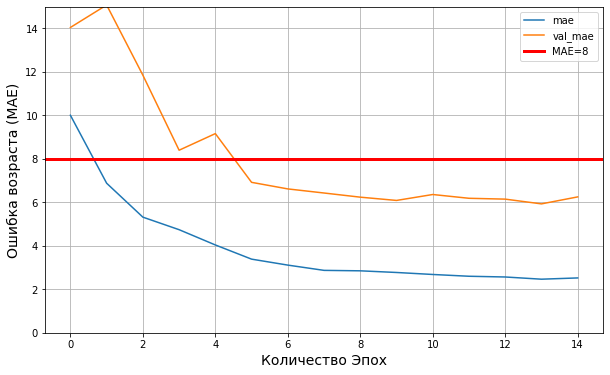

In [18]:
plot_mae(history)

# Вывод

Как видно из графика наша модель на базе ResNet50 смогла достигнуть требуемой точности после 5 эпох обучения. Цель достигнута по метрике. Однако наша модель не сможет контролировать добросовестность продавцов при продаже алкоголя, так как ошибка существенная для возрастов 18-25 лет. Но с первой задачей по рекомендациям модель справится отлично.

Последние 10 эпох обучения никак не сказываются на уменьшении ошибки, соответственно данная модель достигла макисмума своих возможностей.